<a href="https://colab.research.google.com/github/Ale-Cie/Titanic_Disaster_ML/blob/main/Titanic_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Titanic Disaster ML Notebook

In this notebook we will go through the dataset available in the Kaggle competiton which can be found under this <a href="https://www.kaggle.com/competitions/titanic/">link</a>.

If we begin by reading the competition's overview we quickly learn that we're faced with a binary classification task. By following the Scikit-Learn model selection map we get a few suggestions already - `LinearSVC()`, `KNeighborsClassifier()`,`DecisionTreeClassifier()` and if all else fails the `RandomForestClassifier()`. From previous experiences I know that `LogisticRegression()` works pretty good with binary classification as well.

We will roughly follow these steps:
 - Defining the problem (Which Kaggle kindly did for us)
 - Exploring the data
 - Create initial model(s) and tuning the hyperparameters
 - Evaluating the model(s) 
 - Experimenting untill satisfied 

Let's start by importing all the tools we will need.

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import os
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm  import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, train_test_split

from warnings import filterwarnings

In [ ]:
filterwarnings("ignore")

## Data exploration and preparation

Here is a quick recap of all the features:

 - Survived: Survival	0 = No, 1 = Yes
 - Pclass: Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
 - Sex: Sex
 - Age: Age in years
 - SibSp: # of siblings / spouses aboard the Titanic
 - Parch: # of parents / children aboard the Titanic
 - Ticket: Ticket number	
 - Fare: Passenger fare
 - Cabin: Cabin number	
 - Embarked:	Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
# Let's load in the training dataset and explore it a bit
try:
  df = pd.read_csv("/content/drive/MyDrive/Titanic ML Comp/train.csv")
except:
  df = pd.read_csv("/kaggle/input/titanic/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
np.sum(df.isna())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
df.shape

(891, 12)

### Data preparation

Looking at the shape of this dataset and the amount of missing "Cabin" data, we probably should remove this column from the DataFrame - even with any manipulation it would not be representative of the actual values.

Passengers with missing "Embarked" values can be easily dropped, and the "Name" column I think can be dropped too, since how the person was named doesn't really influence their survavibility... I can always be proved wrong though.

"Age" column is quite perplexing. One one hand there aren't that many missing values and removing them won't affect the scale of the dataset that much. We could always try making a mean estimate.

Oh and for the "Embarked" and "Sex" columns we will have to make the numerical values out of the text given.

In [ ]:
# We will define a function now, because the exact same changes will have to be made on the test data later on
def data_manipulator(df):
  # Let's start by dropping the entire "Cabin" and "Name" columns and then we will drop all rows with missing values
  df.drop(["Cabin", "Name", "PassengerId"], axis=1, inplace= True)

  # We have to change the index values in the DataFrame after removing rows, since it causes some silly bugs
  # While we're at it let's make a quick loop to turn the alphabetical values in the "Embarked" and "Sex" into numericals
  # Values will go as follows: for Embarked - C=0, Q=1, S=2
  # For Sex - male=0, female=1
  for idx in df.index:
    embarked = df["Embarked"][idx]
    sex = df["Sex"][idx]
    if embarked == "C":
      embarked = 0
    elif embarked == "Q":
      embarked = 1
    elif embarked =="S":
      embarked = 2
    else:
      pass
    if sex == "male":
      sex = 0
    else:
      sex = 1

    df["Embarked"][idx] = embarked
    df["Sex"][idx] = sex

  # Here I will attempt to turn "object" type tickets into int64 tickets by cutting off the letters
  #I doubt it's a good practice but for now it should do
  ticket_list = []
  for ticket in df["Ticket"]:
    new_ticket = ""
    for char in ticket:
      if char.isnumeric():
        new_ticket += char
      else:
        continue
    if new_ticket == "":
      new_ticket = None
    ticket_list.append(new_ticket)

  df["Ticket"] = ticket_list

  df.dropna(inplace= True)
  df = df.astype({"Embarked": "int64", "Sex": "int64", "Ticket": "int64"})
  return df

df = data_manipulator(df)


In [ ]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,0,22.0,1,0,521171,7.2500,2
1,1,1,1,38.0,1,0,17599,71.2833,0
2,1,3,1,26.0,0,0,23101282,7.9250,2
3,1,1,1,35.0,1,0,113803,53.1000,2
4,0,3,0,35.0,0,0,373450,8.0500,2


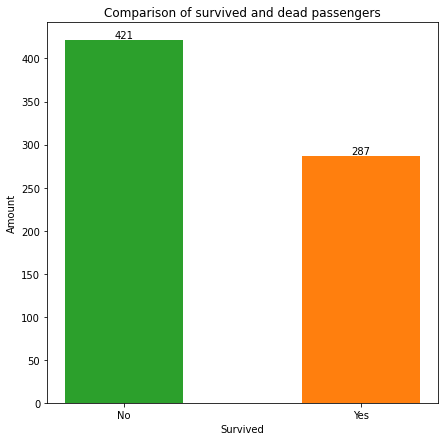

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.bar(x=["No", "Yes"], height=df["Survived"].value_counts(), color=["tab:green", "tab:orange"], width=0.5)
plt.title("Comparison of survived and dead passengers")
plt.xlabel("Survived")
plt.ylabel("Amount")
for container in ax.containers:
  ax.bar_label(container);



In [ ]:
df.dtypes

Survived      int64
Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Ticket        int64
Fare        float64
Embarked      int64
dtype: object

Now that we have numerical values in all columns we can start dividing data into X, y, train and validation sets and start experimenting with different models

### X & y sets creation

Although we are using `train_test_split` we have to remember that we will be dividing our DataFrame into 'train' set and 'validation' set, since the actual test set is given to us by Kaggle. We will be scoring our models on the validation set and then making real predictions on the test set.

In [ ]:
np.random.seed(31)
# Let's start by creating the X and y sets

X = df.drop(["Survived"], axis=1)
y = df["Survived"]

# Now it's time for creating train and test sets

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.25)

## Modelling

Now that we have our data separated and ready to be used it's time to start the modelling process. I will begin with creating a dictionary of all the imported models

### Instantiating and scoring the default models

We will start by creating default models and checking their accuracy. Next we will go through different means of evaluation and see whitch model performs best and which should be grid searched etc.

In [ ]:
def_models = {
    "LinearSVC": LinearSVC(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

In [ ]:
for name, model in def_models.items():
  print(f"Fitting {name} model...")
  model.fit(X_train, y_train)
  print(f"{name}'s accuracy score is %.3f \n" % (model.score(X_validation, y_validation)*100))


Fitting LinearSVC model...
LinearSVC's accuracy score is 66.667 

Fitting KNeighborsClassifier model...
KNeighborsClassifier's accuracy score is 58.004 

Fitting LogisticRegression model...
LogisticRegression's accuracy score is 58.380 

Fitting DecisionTreeClassifier model...
DecisionTreeClassifier's accuracy score is 76.648 

Fitting RandomForestClassifier model...
RandomForestClassifier's accuracy score is 80.979 



The results are in and... They're not very good at the first glance. We can see that the best estimations were done by the two most complex of the tested models - `DecisionTreeClassifier()` and `RandomForestClassifier()`. We'll follow along with those.

The reasons to consider are:
- Bad data engineering (that would be on me)
- Bad choice of the estimators (unlikely since these were advised by scikit-learn documentation)
- Not enough data (possible, but there's nothing we can really do)
- Just need to tune the hyperparameters

### Tuning hyperparameters

We will start the next step by creating a rather extensive parameter grid which will be used first in `RandomizedSearchCV()`. Afterwards we will (probably) trim it down a bit and put it into `GridSearchCV()`.

#### `RandomizedSearchCV()` hyperparameter tuning

We will begin with `RandomizedSearchCV()` so we need to create two separate parameter grids.

##### `DecisionTreeClassifier()`

In [ ]:
dt_param_grid = {
    "splitter": ["best", "random"],
    "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "min_samples_leaf": range(2, 30, 3),
    "min_samples_split": range(2, 50, 4),
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"]
}

In [ ]:
randsearch_dt = RandomizedSearchCV(
    estimator= DecisionTreeClassifier(),
    param_distributions= dt_param_grid,
    n_iter= 100,
    cv= 5,
    verbose= True
)
np.random.seed(31)
randsearch_dt.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': range(2, 30, 3),
                                        'min_samples_split': range(2, 50, 4),
                                        'splitter': ['best', 'random']},
                   verbose=True)

In [ ]:
print(f"RandomizedSearchCV DecisionTreeClassifier model score equals: %.3f " % (randsearch_dt.score(X_validation, y_validation)*100))

RandomizedSearchCV DecisionTreeClassifier model score equals: 73.070 


In [ ]:
for key, value in randsearch_dt.best_params_.items():
  print(f"{key}: {value}")

splitter: best
min_samples_split: 30
min_samples_leaf: 5
max_features: log2
max_depth: 40
criterion: gini


##### `RandomForestClassifier()`

In [ ]:
rf_param_grid = {
  "bootstrap": [True, False],
  "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
  "max_features": ['auto', 'sqrt'],
  "min_samples_leaf": range(2, 30, 3),
  "min_samples_split": range(2, 50, 4),
  "n_estimators": [64, 128, 200, 256, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
  "warm_start": [True, False]
}

In [ ]:
randsearch_rf = RandomizedSearchCV(
    estimator= RandomForestClassifier(),
    param_distributions= rf_param_grid,
    n_iter= 100,
    cv= 5,
    verbose= True
)
np.random.seed(31)
randsearch_rf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': range(2, 30, 3),
                                        'min_samples_split': range(2, 50, 4),
                                        'n_estimators': [64, 128, 200, 256, 400,
                                                         600, 800, 1000, 1200,
                                                         1400, 1600, 1800,
                                                         2000],
                                        'warm_start': [True, False]},
                   verbose=True)

In [ ]:
print(f"RandomizedSearchCV RandomForesClassifier model score equals: %.3f " % (randsearch_rf.score(X_validation, y_validation)*100))

RandomizedSearchCV RandomForesClassifier model score equals: 81.544 


In [ ]:
for key, value in randsearch_rf.best_params_.items():
  print(f"{key}: {value}")

warm_start: True
n_estimators: 1800
min_samples_split: 18
min_samples_leaf: 5
max_features: sqrt
max_depth: 40
bootstrap: False


By the looks of it this result is fairly consistent with the default model, so I have high hopes we are not troubled by over-fitting. Next step is trying to find an even better model with `GridSearchCV()` but since `RandomizedSearchCV()` took us somewhere between 10-15 minutes we have to trim some values from our parameter grid. I will do it with the help of current best parameters.

#### `GridSearchCV()` hyperparameter tuning

Let's start by remembering what parameter grids we used and comparing them to the `best_params_`:

##### `DecisionTreeClassifier()`

In [ ]:
for key, value in dt_param_grid.items():
  print(f"{key}: {value}")

splitter: ['best', 'random']
max_depth: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
min_samples_leaf: range(2, 30, 3)
min_samples_split: range(2, 50, 4)
max_features: ['sqrt', 'log2']
criterion: ['gini', 'entropy']


In [ ]:
for key, value in randsearch_dt.best_params_.items():
  print(f"{key}: {value}")

splitter: best
min_samples_split: 30
min_samples_leaf: 5
max_features: log2
max_depth: 40
criterion: gini


In [ ]:
dt_param_grid_2 = {
    "splitter": ["best", "random"],
    "max_depth": [10, 30, 60, 100, None],
    "min_samples_leaf": [5, 8, 14, 23, 29],
    "min_samples_split": [10, 22, 34, 46],
    "max_features": ["sqrt"],
    "criterion": ["gini", "entropy"]
}

In [ ]:
gridsearch_dt = GridSearchCV(
    estimator= DecisionTreeClassifier(),
    param_grid= dt_param_grid_2,
    cv= 5,
    verbose= True
)

np.random.seed(31)
gridsearch_dt.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 30, 60, 100, None],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [5, 8, 14, 23, 29],
                         'min_samples_split': [10, 22, 34, 46],
                         'splitter': ['best', 'random']},
             verbose=True)

In [ ]:
print(f"GridSearchCV DecisionTreeClassifier model score equals: %.3f " % (gridsearch_dt.score(X_validation, y_validation)*100))

GridSearchCV DecisionTreeClassifier model score equals: 70.810 


In [ ]:
gridsearch_dt.best_params_

{'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 22,
 'splitter': 'best'}

##### `RandomForestClassifier()`

In [ ]:
for key, value in rf_param_grid.items():
  print(f"{key}: {value}")

bootstrap: [True, False]
max_depth: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
max_features: ['auto', 'sqrt']
min_samples_leaf: range(2, 30, 3)
min_samples_split: range(2, 50, 4)
n_estimators: [64, 128, 200, 256, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
warm_start: [True, False]


In [ ]:
for key, value in randsearch_rf.best_params_.items():
  print(f"{key}: {value}")

warm_start: True
n_estimators: 1800
min_samples_split: 18
min_samples_leaf: 5
max_features: sqrt
max_depth: 40
bootstrap: False


In [ ]:
rf_param_grid_2 = {
    "bootstrap": [True],
    "max_depth": [None, 10, 40, 80],
    "max_features": ["sqrt"],
    "min_samples_leaf": [2, 5, 14, 20],
    "min_samples_split": [2, 6, 18, 42],
    "n_estimators": [128, 256, 800, 1200],
    "warm_start": [True]    
}

In [ ]:
gridsearch_rf = GridSearchCV(
    estimator= RandomForestClassifier(),
    param_grid= rf_param_grid_2,
    cv= 5,
    verbose= True
)
np.random.seed(31)
gridsearch_rf.fit(X_train, y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [None, 10, 40, 80],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 5, 14, 20],
                         'min_samples_split': [2, 6, 18, 42],
                         'n_estimators': [128, 256, 800, 1200],
                         'warm_start': [True]},
             verbose=True)

In [ ]:
print(f"GridSearchCV RandomForestClassifier model score equals: %.3f " % (gridsearch_rf.score(X_validation, y_validation)*100))

GridSearchCV RandomForestClassifier model score equals: 81.356 


In [ ]:
for key, value in gridsearch_rf.best_params_.items():
  print(f"{key}: {value}")

bootstrap: True
max_depth: None
max_features: sqrt
min_samples_leaf: 2
min_samples_split: 6
n_estimators: 800
warm_start: True


## Evaluation

Next step is evaluating the models. We will do it via these measures:
- ROC Curve and AUC score
- Confusion matrix
- Classification report
- Accuracy
- Precision
- Recall
- F1-score

First three of them can be done on the `best_estimator` models found in our searches. 

The last four however will be done differently - we will have to create new instances of these models, with hyperparameters found through `RandomizedSearchCV()` and `GridSearchCV()`. Next, we will define a function to test the metrics using the `cross_val_score` and we will check their performance, and in the end choose, fit and use the best one of them to make predictions on the test set provided by Kaggle.

### ROC Curve an AUC score


#### `DecisionTreeClassifier()`

In [ ]:
y_randsearch_dt_preds = randsearch_dt.best_estimator_.predict_proba(X_validation)[::,1]
y_gridsearch_dt_preds = gridsearch_dt.best_estimator_.predict_proba(X_validation)[::,1]

evaluated_dt_models = {
    "RandomizedSearchCV model": randsearch_dt.best_estimator_,
    "GridSearchCV model": gridsearch_dt.best_estimator_
}


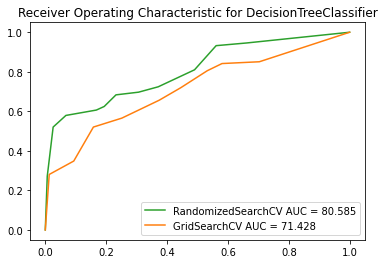

In [ ]:
# Plotting the ROC Curve

randsearch_dt_fpr, randsearch_dt_tpr, randsearch_dt_threshold = roc_curve(y_validation, y_randsearch_dt_preds)
gridsearch_dt_fpr, gridsearch_dt_tpr, gridsearch_dt_threshold = roc_curve(y_validation, y_gridsearch_dt_preds)

randsearch_dt_auc = auc(randsearch_dt_fpr, randsearch_dt_tpr)
gridsearch_dt_auc = auc(gridsearch_dt_fpr, gridsearch_dt_tpr)

fig, ax = plt.subplots()
plt.title("Receiver Operating Characteristic for DecisionTreeClassifier")
plt.plot(randsearch_dt_fpr, randsearch_dt_tpr, label="RandomizedSearchCV AUC = %0.3f"%(randsearch_dt_auc*100), color="tab:green")
plt.plot(gridsearch_dt_fpr, gridsearch_dt_tpr, label="GridSearchCV AUC = %0.3f"%(gridsearch_dt_auc*100), color="tab:orange")
plt.legend(loc="lower right");


#### `RandomForrestClassifier()`

In [ ]:
y_randsearch_rf_preds = randsearch_rf.best_estimator_.predict_proba(X_validation)[::,1]
y_gridsearch_rf_preds = gridsearch_rf.best_estimator_.predict_proba(X_validation)[::,1]

evaluated_rf_models = {
    "RandomizedSearchCV model": randsearch_rf.best_estimator_,
    "GridSearchCV model": gridsearch_rf.best_estimator_
}


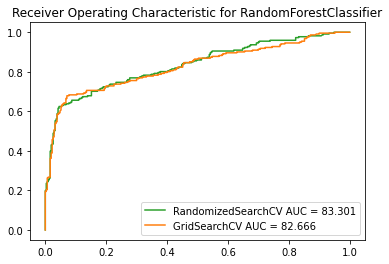

In [ ]:
# Plotting the ROC Curve

randsearch_rf_fpr, randsearch_rf_tpr, randsearch_rf_threshold = roc_curve(y_validation, y_randsearch_rf_preds)
gridsearch_rf_fpr, gridsearch_rf_tpr, gridsearch_rf_threshold = roc_curve(y_validation, y_gridsearch_rf_preds)

randsearch_rf_auc = auc(randsearch_rf_fpr, randsearch_rf_tpr)
gridsearch_rf_auc = auc(gridsearch_rf_fpr, gridsearch_rf_tpr)

fig, ax = plt.subplots()
plt.title("Receiver Operating Characteristic for RandomForestClassifier")
plt.plot(randsearch_rf_fpr, randsearch_rf_tpr, label="RandomizedSearchCV AUC = %0.3f"%(randsearch_rf_auc*100), color="tab:green")
plt.plot(gridsearch_rf_fpr, gridsearch_rf_tpr, label="GridSearchCV AUC = %0.3f"%(gridsearch_rf_auc*100), color="tab:orange")
plt.legend(loc="lower right");


### Confusion Matrix

#### `DecisionTreeClassifier()`

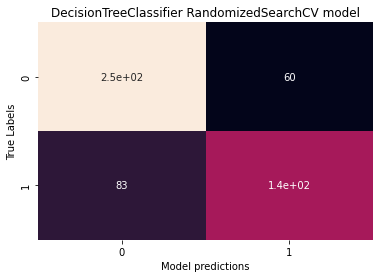

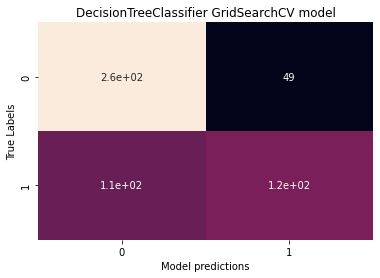

In [ ]:
def plot_conf_mat(y_test, y_preds, name):
  fig, ax = plt.subplots()
  ax = sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cbar=False)
  plt.title("DecisionTreeClassifier "+ name)
  plt.xlabel("Model predictions")
  plt.ylabel("True Labels")

for name, model in evaluated_dt_models.items():
  plot_conf_mat(y_validation, model.predict(X_validation), name)

#### `RandomForestClassifier()`

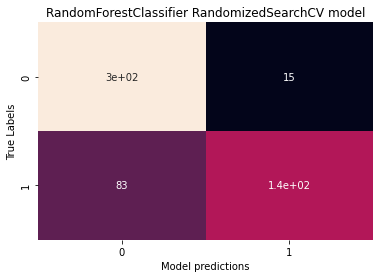

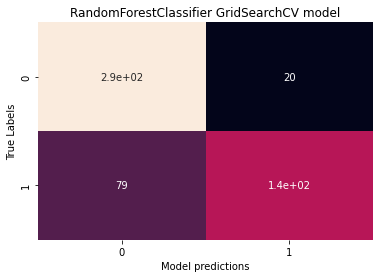

In [ ]:
def plot_conf_mat(y_test, y_preds, name):
  fig, ax = plt.subplots()
  ax = sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cbar=False)
  plt.title("RandomForestClassifier "+ name)
  plt.xlabel("Model predictions")
  plt.ylabel("True Labels")

for name, model in evaluated_rf_models.items():
  plot_conf_mat(y_validation, model.predict(X_validation), name)

###Classification Report

#### `DecisionTreeClassifier()`

In [ ]:
for name, model in evaluated_dt_models.items():
  print(f"Classification report for DecisionTreeClassifier() {name}:\n\n{classification_report(y_validation, model.predict(X_validation))}")

Classification report for DecisionTreeClassifier() RandomizedSearchCV model:

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       310
           1       0.70      0.62      0.66       221

    accuracy                           0.73       531
   macro avg       0.72      0.72      0.72       531
weighted avg       0.73      0.73      0.73       531

Classification report for DecisionTreeClassifier() GridSearchCV model:

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       310
           1       0.70      0.52      0.60       221

    accuracy                           0.71       531
   macro avg       0.71      0.68      0.68       531
weighted avg       0.71      0.71      0.70       531



#### `RandomForestClasiifier()`

In [ ]:
for name, model in evaluated_rf_models.items():
  print(f"Classification report for RandomForestClassifier() {name}:\n\n{classification_report(y_validation, model.predict(X_validation))}")

Classification report for RandomForestClassifier() RandomizedSearchCV model:

              precision    recall  f1-score   support

           0       0.78      0.95      0.86       310
           1       0.90      0.62      0.74       221

    accuracy                           0.82       531
   macro avg       0.84      0.79      0.80       531
weighted avg       0.83      0.82      0.81       531

Classification report for RandomForestClassifier() GridSearchCV model:

              precision    recall  f1-score   support

           0       0.79      0.94      0.85       310
           1       0.88      0.64      0.74       221

    accuracy                           0.81       531
   macro avg       0.83      0.79      0.80       531
weighted avg       0.82      0.81      0.81       531



### Cross-Validated Metrics

We will start by definig two functions - one that will run all necessary evaluation metrics on new instances of the `DecisionTreeClassifier()` and `RandomizedSearchCV()` models and the second one that will plot these metrics as bar plots.

In [ ]:
def cross_val_metrics(model, X, y):
    """This function takes a model and measures it's performance through cross validation"""
    cv_results = {}
    cv_results["Accuracy"] = np.mean(cross_val_score(model, X, y, cv= 5, scoring= "accuracy"))
    cv_results["Precision"] = np.mean(cross_val_score(model, X, y, cv=5, scoring="precision"))
    cv_results["Recall"] = np.mean(cross_val_score(model, X, y, cv=5, scoring="recall"))
    cv_results["F1-score"] = np.mean(cross_val_score(model, X, y, cv=5, scoring="f1"))

    return pd.DataFrame(cv_results, index=[0])

def plot_cv_metrics(estimators_dict, X, y):
  idx = 0
  for name, estimator in estimators_dict.items():
    cross_val_scores = cross_val_metrics(estimator, X, y)
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.bar(x=cross_val_scores.columns, height=cross_val_scores.values[0], width=0.5, color=colors[idx])
    plt.title(f"Cross-validated scores of {name}")
    for container in ax.containers:
      ax.bar_label(container)
    idx +=1

##### Instantiating new estimators

Here we create two dictionaries of estimators - dt (DecisionTreeClassifiers) and rf (RandomForestClassifiers) which will be used in order to run `plot_cv_metrics` and which in turn will run `cross_val_metrics`.  

In [ ]:
dt_estimators_dict = {
    "Default DecisionTree": DecisionTreeClassifier(),
    "RandomizedSearch DecisionTree": DecisionTreeClassifier(
        splitter= "best",
        min_samples_split= 46,
        min_samples_leaf= 14,
        max_features= "sqrt",
        max_depth= 60,
        criterion= "gini"
    ),
    "GridSearch DecisionTree": DecisionTreeClassifier(
        criterion= 'gini',
        max_depth= 100,
        max_features= 'sqrt',
        min_samples_leaf= 14,
        min_samples_split= 46,
        splitter= 'best'
    )
}
rf_estimators_dict = {
    "Default RandomForest": RandomForestClassifier(),
    "RandomizedSearch RandomForest": RandomForestClassifier(
        warm_start= True,
        n_estimators= 1200,
        min_samples_split= 6,
        min_samples_leaf= 5,
        max_features= "sqrt",
        max_depth= None,
        bootstrap= True
    ),
    "GridSearch RandomForest": RandomForestClassifier(
        bootstrap= True,
        max_depth= None,
        max_features= "sqrt",
        min_samples_leaf= 2,
        min_samples_split= 2,
        n_estimators= 1200,
        warm_start= True
    )
}

colors = ["tab:green", "tab:orange", "tab:blue"]


##### Cross-validated metrics of `DecisionTree()` estimators

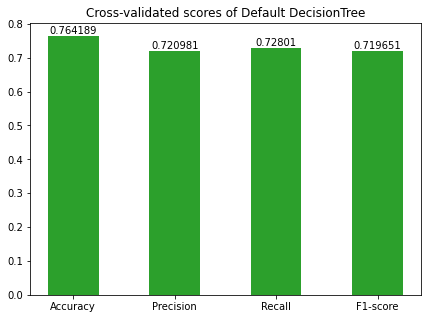

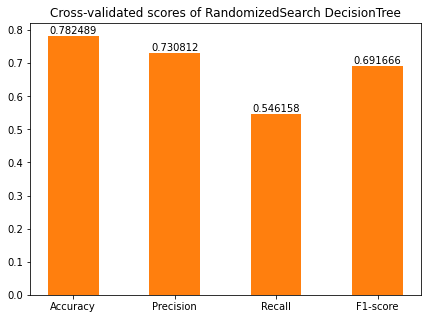

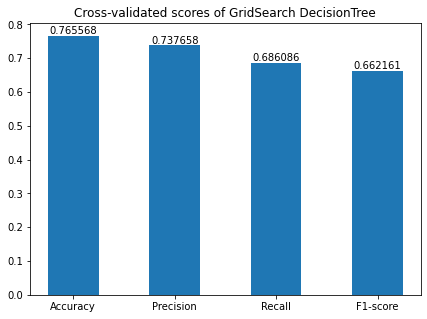

In [ ]:
plot_cv_metrics(dt_estimators_dict, X, y)

##### Cross-validated metrics of `RandomForestClassifier()` estimators

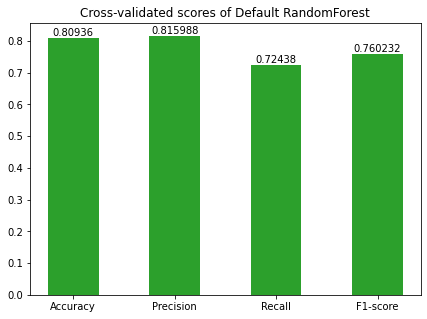

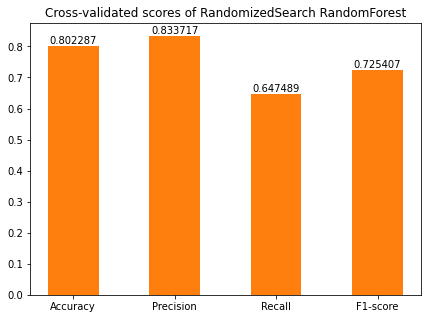

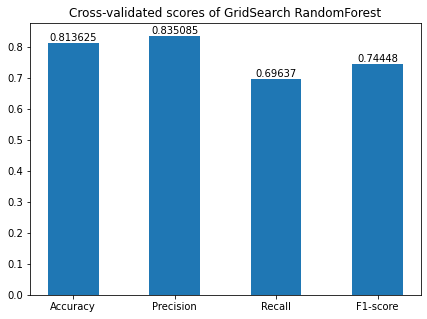

In [ ]:
plot_cv_metrics(rf_estimators_dict, X, y)

## Feature Importances
After all the experimentation and calculating different metrics I think it's best to go with the `GridSearchCV()` version of the `RandomForestClassifier()`. We will recreate it for the last time, fit it on the whole data set and we can as one final attempt at improving it see which features were the least important.

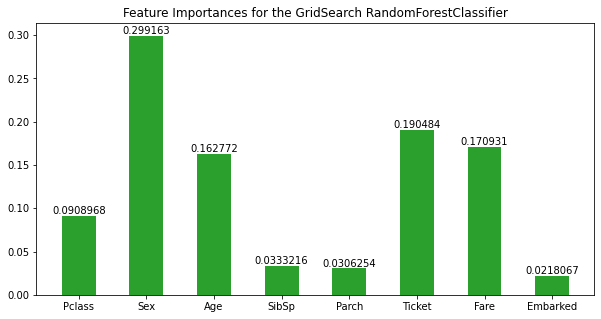

In [ ]:
random_forest_clf = rf_estimators_dict["GridSearch RandomForest"]
random_forest_clf.fit(X, y)
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(x=X.columns, height=random_forest_clf.feature_importances_, width=0.5, color="tab:green")
plt.title("Feature Importances for the GridSearch RandomForestClassifier")
for container in ax.containers:
  ax.bar_label(container)


Judging by this plot we could attempt to do one final round of experimentation on this model by recreating the X set without the "Embarked", "Parch" and "SibSp" columns... Let's try it out now 

### Testing the "leaner" DataFrame

In [ ]:
rf_estimators_dict = {
    "Default RandomForest": RandomForestClassifier(),
    "RandomizedSearch RandomForest": RandomForestClassifier(
        warm_start= True,
        n_estimators= 1200,
        min_samples_split= 6,
        min_samples_leaf= 5,
        max_features= "sqrt",
        max_depth= None,
        bootstrap= True
    ),
    "GridSearch RandomForest": RandomForestClassifier(
        bootstrap= True,
        max_depth= None,
        max_features= "sqrt",
        min_samples_leaf= 2,
        min_samples_split= 2,
        n_estimators= 1200,
        warm_start= True
    )
}

new_X = X.drop(columns=["Embarked", "Parch", "SibSp"], axis=1)
new_y = y

np.random.seed(31)
new_X_train, new_X_validation, new_y_train, new_y_validation = train_test_split(new_X, new_y, train_size=0.25)

for name, estimator in rf_estimators_dict.items():
  clf = estimator
  clf.fit(new_X_train, new_y_train)
  print(f"Accuracy score of the {name} equals: %.3f \n\n"% (clf.score(new_X_validation, new_y_validation)*100) )
  


Accuracy score of the Default RandomForest equals: 79.849 


Accuracy score of the RandomizedSearch RandomForest equals: 80.603 


Accuracy score of the GridSearch RandomForest equals: 80.414 




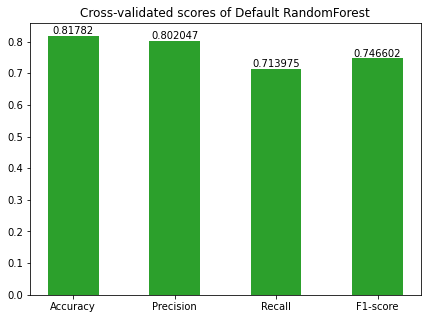

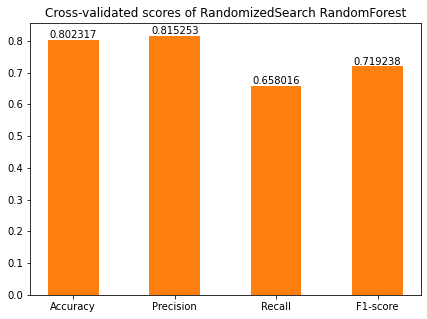

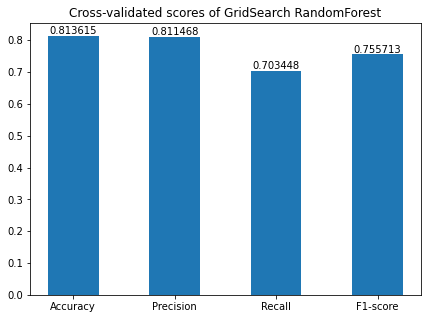

In [ ]:
plot_cv_metrics(rf_estimators_dict, new_X, new_y)

By the looks of it the best version to use i actually the `GridSearchCV()` `RandomForestClassifier()` trained on a regular DataFrame... There's nothing left to do but load in the train set and then just crop it down to our current standard, make the predictions and call it a day.

## Final model and preparations for making the final prediction

We will start by recreating the most promising of all the tested models and fit it with the whole DataFrame `X` and the "Survived" `y` set. Next step will consist of loading in the test data from the Kaggle competition and engineering it in the way as close to the original as possible. For now we will do it by hacking off parts of the original function. I plan to modify the original function however so that it works on both train and test data

In [60]:
clf = RandomForestClassifier(
    bootstrap= True,
    max_depth= None,
    max_features= "sqrt",
    min_samples_leaf= 2,
    min_samples_split= 2,
    n_estimators= 1200,
    warm_start= True
)

clf.fit(X, y)

RandomForestClassifier(min_samples_leaf=2, n_estimators=1200, warm_start=True)

In [61]:
try:  
  test_df = pd.read_csv("/content/drive/MyDrive/Titanic ML Comp/test.csv")
except:
  test_df = pr.read_csv("/kaggle/input/titanic/test.csv")
print(np.sum(test_df.isna())), print(test_df.shape), print(test_df.dtypes);

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
(418, 11)
PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


While we could remove the rows with missing values from the training and validation sets we can't do that here...

What we'll have to do is create mean estimates of the missing values. Except for "Cabin" of course. We can drop an entire column there...

We will sadly have to hack parts off of our `data_manipulator` function and use them here.

In [62]:
passengers_ids = []
for id in test_df["PassengerId"]:
  passengers_ids.append(id)
# Let's start by dropping the entire "Cabin", "Name", "Embarked", "Parch" and "SibSp" columns
test_df.drop(["Cabin", "Name", "PassengerId"], axis=1, inplace= True)

# Nex step is making the estimations in the missing "Age" and "Fare" columns.
test_df.fillna(value={"Age": np.mean(test_df["Age"]), "Fare": np.mean(test_df["Fare"])}, inplace=True)

# We also have to remember that we have to change the dtypes into int64 which means changing categoricals into numbers
for idx in test_df.index:
    embarked = test_df["Embarked"][idx]
    sex = test_df["Sex"][idx]
    if embarked == "C":
      embarked = 0
    elif embarked == "Q":
      embarked = 1
    elif embarked =="S":
      embarked = 2
    else:
      pass
    if sex == "male":
      sex = 0
    else:
      sex = 1

    test_df["Embarked"][idx] = embarked
    test_df["Sex"][idx] = sex

  # Here I will attempt to turn "object" type tickets into int64 tickets by cutting off the letters
  #I doubt it's a good practice but for now it should do
  
ticket_list = []
for ticket in test_df["Ticket"]:
  new_ticket = ""
  for char in ticket:
    if char.isnumeric():
      new_ticket += char
    else:
      continue
  if new_ticket == "":
    new_ticket = None
  ticket_list.append(new_ticket)

test_df["Ticket"] = ticket_list

test_df = test_df.astype({"Sex": "int64", "Ticket": "int64", "Embarked": "int64"})


print(np.sum(test_df.isna())), print(test_df.shape), print(test_df.dtypes);

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64
(418, 8)
Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Ticket        int64
Fare        float64
Embarked      int64
dtype: object


In [63]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,0,34.5,0,0,330911,7.8292,1
1,3,1,47.0,1,0,363272,7.0000,2
2,2,0,62.0,0,0,240276,9.6875,1
3,3,0,27.0,0,0,315154,8.6625,2
4,3,1,22.0,1,1,3101298,12.2875,2


## Making predictions and preparing the "solution.csv" file

Final step in this notebook is making the 'predictions' array. Then we will put it alongside the PassengerIds into a DataFrame and export it to .csv file. 

In [64]:
predictions = clf.predict(test_df)

print(len(passengers_ids)), print(len(predictions))

418
418


(None, None)

In [65]:
solutions = pd.DataFrame(columns=["PassengerId", "Survived"])
solutions["PassengerId"] = passengers_ids
solutions["Survived"] = predictions

solutions.to_csv(index=False, path_or_buf="/content/drive/MyDrive/Titanic ML Comp/solution.csv")

## Final thoughts

This "solution.csv" file is ready for submission on Kaggle - this iteration of our estimator performed at 76.555 % accuracy. That's not great but quite sattisfying for now, since I will probably return to this notebook at a later date. From what I learned my data manipulation was quite okay, since I did what most people do with these columns. 

I'm just surprised that the model did at around 81% accuracy on the validation set but did worse on the actual test data. Still, that's something we can work on with XGBoost, CatBoost or just popping our problem into Auto-ML.

For now that's it, I'm quite happy about this notebook and how it worked out. Especially for something done in few free minutes between patietns.

Cheers for now, see you round.
